# Demo 6: Coding the 5-Step Training Loop in PyTorch

Neural networks learn by adjusting their weights to reduce loss, guided by gradients computed through backpropagation and applied by optimizers. But how do these abstract concepts translate into actual code?

> **Overview**: We'll build the complete PyTorch training loop: the five-step cycle that powers every deep learning model. You'll see exactly how forward passes, loss computation, backpropagation, and weight updates work together to make a model learn.
> 
> **Scenario**: Your e-commerce platform sells used cars and needs to predict prices based on specifications like make, model, year, engine size, and fuel type. The current model's predictions are inconsistent: some car types learn well while others don't. You need to understand how learning actually happens and ensure the training loop runs correctly so predictions improve with each iteration.
> 
> **Goal**: Understand the five fundamental steps that make neural networks learn, and see how PyTorch automates the complex mathematics behind gradient descent and backpropagation.
> 
> **Tools**: Python, PyTorch, NumPy, Matplotlib

## Step 1: Setup

Let's start by importing our libraries and setting up our environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory for visualizations
output_dir = 'assets/demo6'
os.makedirs(output_dir, exist_ok=True)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Setup complete!\n")

Using device: cuda
Setup complete!



## Step 2: Load and prepare the data

We'll use the [Vishaltiwari2019/Car-Price-Prediction](https://huggingface.co/datasets/Vishaltiwari2019/Car-Price-Prediction) dataset that contains specifications and prices for 1,000 vehicles. Our goal is to predict the price based on features like make, model, year, engine size, mileage, fuel type, and transmission.

For preprocessing, we'll:
1. Load the dataset
2. Encode categorical features (Make, Model, Fuel Type, Transmission)
3. Separate features and label
3. Normalize numerical features for stable training
5. Convert features and labels to PyTorch tensors

**IMPORTANT: Feel free to skip this section to focus on the training loop itself**. Just know that we end up with 1,000 training examples, each with 7 features (encoded and normalized), predicting a continuous price value.

In [2]:
# 1. Load the dataset from Hugging Face
dataset = load_dataset('Vishaltiwari2019/Car-Price-Prediction', split='train')
df = pd.DataFrame(dataset)

print(f"✓ Dataset loaded: {len(df)} cars found\n")
print("Sample of the data:")
print(df.head())
print(f"\nPrice range: ${df['Price'].min():.2f} - ${df['Price'].max():.2f}")

✓ Dataset loaded: 1000 cars found

Sample of the data:
    Make    Model  Year  Engine Size  Mileage Fuel Type Transmission  \
0  Honda  Model B  2015          3.9    74176    Petrol       Manual   
1   Ford  Model C  2014          1.7    94799  Electric    Automatic   
2    BMW  Model B  2006          4.1    98385  Electric       Manual   
3  Honda  Model B  2015          2.6    88919  Electric    Automatic   
4  Honda  Model C  2004          3.4   138482    Petrol    Automatic   

          Price  
0  30246.207931  
1  22785.747684  
2  25760.290347  
3  25638.003491  
4  21021.386657  

Price range: $6704.95 - $41780.50


> **Understanding the data**: Each row represents a used car listing with 7 features that influence pricing. The prices range from about $6,700 to $41,800, reflecting the diversity of vehicles from older high-mileage cars to newer low-mileage ones. Notice how features have different scales: 
> - Year ranges from 2004-2019
> - Engine Size from 1.0-4.5L
> - Mileage from 50k-200k miles
> 
> This varying scale is why we'll normalize the data before training as it helps the network learn more efficiently.

In [3]:
# 2. Encode categorical variables
label_encoders = {}
categorical_columns = ['Make', 'Model', 'Fuel Type', 'Transmission']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("✓ Categorical variables encoded")
print(f"\nEncoded data sample:")
print(df.head())

✓ Categorical variables encoded

Encoded data sample:
   Make  Model  Year  Engine Size  Mileage  Fuel Type  Transmission  \
0     3      1  2015          3.9    74176          2             1   
1     2      2  2014          1.7    94799          1             0   
2     1      1  2006          4.1    98385          1             1   
3     3      1  2015          2.6    88919          1             0   
4     3      2  2004          3.4   138482          2             0   

          Price  
0  30246.207931  
1  22785.747684  
2  25760.290347  
3  25638.003491  
4  21021.386657  


> **Understanding categorical encoding**: Neural networks only understand numbers, not text labels like "Ford" or "Manual". LabelEncoder converts each unique category to a number (e.g., Ford→0, Honda→1, BMW→2). More sophisticated encoding methods include one-hot encoding for categorical features without inherent order.

In [4]:
# 3. Separate features and target
X = df.drop('Price', axis=1).values
y = df['Price'].values.reshape(-1, 1)

# 4. Normalize features
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# 5. Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

print(f"\n✓ Data prepared for training")
print(f"Total samples: {len(X)}")
print(f"Input features: {X.shape[1]}")


✓ Data prepared for training
Total samples: 1000
Input features: 7


> **A note on train/test splits**: In this demo, we're using all 1,000 samples for training to keep the focus on understanding the 5-step training loop. In real-world practice, you would split your data into separate training and test sets to evaluate how well your model generalizes to unseen data during training. 
> 
> For now, let's focus on watching the model learn through the training loop!

## Step 3: Build the model

We'll create a simple feedforward neural network with two hidden layers. This architecture is appropriate for small tabular data like ours: enough capacity to learn complex pricing patterns without overfitting on 1,000 training examples.

In [5]:
class PricePredictionModel(nn.Module):
    """
    A simple feedforward neural network for regression.
    
    Architecture: 7 inputs -> 64 neurons -> 32 neurons -> 1 output
    """
    def __init__(self, input_size=7):
        super(PricePredictionModel, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x):
        """
        Forward pass through the network.
        """
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation on output for regression
        return x

# Create the model
model = PricePredictionModel(input_size=7)
print("✓ Model created")
print(f"\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

✓ Model created

Model architecture:
PricePredictionModel(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

Total parameters: 2,625


> **Architecture choices**: 
> - **Activations**: ReLU after hidden layers (introduces non-linearity), but no activation on the output layer since we're predicting continuous prices, not probabilities
> - **Layer sizes**: 64 → 32 neurons, gradually narrowing to a single output
> - **Model capacity**: ~2,500 parameters with 1,000 training samples gives us a reasonable ratio that should allow the model to learn effectively

## Step 4: See the model's initial predictions (before training)

Let's make predictions with the randomly initialized weights to see how bad the model is before any learning.

In [6]:
# Make predictions with untrained model (on first 200 samples)
with torch.no_grad():
    initial_predictions = model(X_tensor[:200]).numpy()
    
# Convert back to original price scale
initial_predictions_orig = scaler_y.inverse_transform(initial_predictions)
y_orig = scaler_y.inverse_transform(y[:200])

print("Untrained model predictions (first 5 examples):")
print("-" * 50)
for i in range(5):
    print(f"Actual: ${y_orig[i, 0]:>8,.2f}  |  Predicted: ${initial_predictions_orig[i, 0]:>8,.2f}  |  Error: ${abs(y_orig[i, 0] - initial_predictions_orig[i, 0]):>8,.2f}")

# Calculate average error
avg_error = np.mean(np.abs(y_orig - initial_predictions_orig))
print(f"\nAverage absolute error: ${avg_error:,.2f}")
print("\n✖ The model is basically guessing! Let's train it...")

Untrained model predictions (first 5 examples):
--------------------------------------------------
Actual: $30,246.21  |  Predicted: $24,767.50  |  Error: $5,478.71
Actual: $22,785.75  |  Predicted: $25,218.78  |  Error: $2,433.03
Actual: $25,760.29  |  Predicted: $25,037.17  |  Error: $  723.12
Actual: $25,638.00  |  Predicted: $25,181.63  |  Error: $  456.37
Actual: $21,021.39  |  Predicted: $25,182.86  |  Error: $4,161.47

Average absolute error: $4,053.68

✖ The model is basically guessing! Let's train it...


> **Understanding initial predictions**: 
> 
> - **Random initialization**: Neural networks start with random weights, so initial predictions are essentially noise. The model has no idea that a 2004 car with high mileage should cost less than a 2019 car with low mileage. Training will teach it these relationships by systematically adjusting weights to reduce prediction errors.
> 
> - **torch.no_grad()**: During training, PyTorch automatically tracks all operations to compute gradients later. But when we're just making predictions (not training), we don't need this tracking—it wastes memory and computation. The `with torch.no_grad():` context tells PyTorch: "just run forward pass, don't track gradients." You'll use this whenever you evaluate a model without updating weights.
> 
> - **Converting to original scale**: We normalized our prices earlier for training stability, but to understand what the model is actually predicting, we convert back to real dollar amounts using `scaler_y.inverse_transform()`. This lets us see that the untrained model is making wildly inaccurate predictions like $15,000 when the actual price is $25,000.

## Step 5: The 5-Step training loop in action

Now comes the heart of deep learning: **the training loop**. Every neural network, whether it's a simple price predictor or GPT-5, learns through these same five steps repeated over and over:

1. **Forward Pass** → Run data through the model to get predictions
2. **Compute Loss** → Measure how wrong the predictions are
3. **Zero Gradients** → Clear old gradient values from the previous iteration
4. **Backward Pass** → Use backpropagation to compute gradients
5. **Update Weights** → Apply the optimizer to adjust weights

Let's first execute one complete training iteration step-by-step to see what happens, then we'll run the full training loop for 100 epochs to watch the model learn.

### 5.1 Walkthrough of a single training step

Let's execute one complete training iteration step-by-step, printing what happens at each stage.

In [7]:
# Set up training components
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Training components:")
print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Learning rate: 0.001")

Training components:
Loss function: MSELoss()
Optimizer: Adam
Learning rate: 0.001


> **Component choices**: 
> - **MSE (Mean Squared Error)** is the standard loss for regression; it penalizes large errors more than small ones. 
> - **Adam** optimizer combines momentum and adaptive learning rates, making it efficient for most tasks. 
>   <br>The learning rate of 0.001 is Adam's recommended default and works well in practice.

In [8]:
# Let's examine one specific weight before training
# We'll track the first weight in the first layer
initial_weight = model.fc1.weight[0, 0].item()
print(f"\nTracking one weight before training:")
print(f"model.fc1.weight[0, 0] = {initial_weight:.6f}")


Tracking one weight before training:
model.fc1.weight[0, 0] = 0.288968


> **Why track a single weight?** With ~2,500 parameters changing simultaneously, it's hard to see what's happening during training. By watching just one weight, we can literally see gradient descent in action: this number will shift slightly with each training step as the optimizer nudges it toward better predictions. 
> 
> It's a tiny change, but multiplied across thousands of weights and iterations, these adjustments accumulate into a trained model.

In [9]:
print("=" * 60)
print("EXECUTING ONE TRAINING STEP")
print("=" * 60)

# ============================================================
# STEP 1: Forward Pass
# ============================================================
print("\n STEP 1: Forward Pass")
print("-" * 60)
predictions = model(X_tensor)
print(f"Input shape: {X_tensor.shape}")
print(f"Output shape: {predictions.shape}")
print(f"Sample prediction: {predictions[0].item():.4f}")
print("✓ Data passed through network, predictions generated")

# ============================================================
# STEP 2: Compute Loss
# ============================================================
print("\n STEP 2: Compute Loss")
print("-" * 60)
loss = criterion(predictions, y_tensor)
print(f"Loss value: {loss.item():.4f}")
print("✓ Measured how wrong predictions are using MSE")

# ============================================================
# STEP 3: Zero Gradients
# ============================================================
print("\n STEP 3: Zero Gradients")
print("-" * 60)
# Check gradient before zeroing (will be None on first iteration)
grad_before = model.fc1.weight.grad
print(f"Gradient before zeroing: {grad_before}")

optimizer.zero_grad()
grad_after = model.fc1.weight.grad
print(f"Gradient after zeroing: {grad_after}")
print("✓ Cleared old gradients to prepare for new computation")

# ============================================================
# STEP 4: Backward Pass (Backpropagation)
# ============================================================
print("\n STEP 4: Backward Pass")
print("-" * 60)
loss.backward()
# Now gradients are computed
sample_gradient = model.fc1.weight.grad[0, 0].item()
print(f"Sample gradient (model.fc1.weight[0, 0]): {sample_gradient:.6f}")
print("✓ Computed gradients for all parameters using backpropagation")

# ============================================================
# STEP 5: Update Weights
# ============================================================
print("\n STEP 5: Update Weights")
print("-" * 60)
weight_before_update = model.fc1.weight[0, 0].item()
print(f"Weight before update: {weight_before_update:.6f}")

optimizer.step()

weight_after_update = model.fc1.weight[0, 0].item()
weight_change = weight_after_update - weight_before_update
print(f"Weight after update:  {weight_after_update:.6f}")
print(f"Change in weight:     {weight_change:.6f}")
print("✓ Applied gradients to update all weights")

print("\n" + "=" * 60)
print("ONE TRAINING STEP COMPLETE!")
print("=" * 60)

EXECUTING ONE TRAINING STEP

 STEP 1: Forward Pass
------------------------------------------------------------
Input shape: torch.Size([1000, 7])
Output shape: torch.Size([1000, 1])
Sample prediction: -0.0713
✓ Data passed through network, predictions generated

 STEP 2: Compute Loss
------------------------------------------------------------
Loss value: 0.9724
✓ Measured how wrong predictions are using MSE

 STEP 3: Zero Gradients
------------------------------------------------------------
Gradient before zeroing: None
Gradient after zeroing: None
✓ Cleared old gradients to prepare for new computation

 STEP 4: Backward Pass
------------------------------------------------------------
Sample gradient (model.fc1.weight[0, 0]): -0.002543
✓ Computed gradients for all parameters using backpropagation

 STEP 5: Update Weights
------------------------------------------------------------
Weight before update: 0.288968
Weight after update:  0.289968
Change in weight:     0.001000
✓ Applied

> **What just happened?** In a fraction of a second, the network:
> 1. Made 1,000 predictions (forward pass)
> 2. Computed how wrong they were (loss)
> 3. Cleared old gradients (zero_grad) !!!
> 4. Calculated exactly how to adjust ~2,500 weights (backward)
> 5. Updated all weights to improve predictions (optimizer.step)
> 
> Notice the weight changed by a small amount (~0.001). The gradient was negative (-0.002543), which means "decreasing this weight would increase the loss", so the optimizer did the opposite: it increased the weight slightly. This tiny adjustment, multiplied across thousands of parameters and repeated many times, is how neural networks learn.

### 5.2: Train for multiple epochs

One training step isn't enough: we need to repeat this cycle many times. An **epoch** is one complete pass through the entire training dataset. 

Let's train for 100 epochs and watch the loss decrease.

In [10]:
# Reset the model for clean training
model = PricePredictionModel(input_size=7)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Track training progress
num_epochs = 100
train_losses = []

print("Training the model...\n")
print(f"{'Epoch':>6} | {'Training Loss':>14}")
print("-" * 25)

for epoch in range(num_epochs):
    # The 5-step training loop
    predictions = model(X_tensor)           # Step 1: Forward pass
    loss = criterion(predictions, y_tensor) # Step 2: Compute loss
    optimizer.zero_grad()                   # Step 3: Zero gradients
    loss.backward()                         # Step 4: Backward pass
    optimizer.step()                        # Step 5: Update weights
    
    train_losses.append(loss.item())
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"{epoch + 1:6d} | {loss.item():14.4f}")

print("\n✓ Training complete!")

Training the model...

 Epoch |  Training Loss
-------------------------
    10 |         0.7813
    20 |         0.5601
    30 |         0.3442
    40 |         0.2060
    50 |         0.1778
    60 |         0.1716
    70 |         0.1623
    80 |         0.1590
    90 |         0.1562
   100 |         0.1543

✓ Training complete!


> **Understanding the training loop**: Each epoch, we run all five steps on the entire dataset. Notice how the loss decreases steadily: this is learning in action! 
> The model starts with random weights that produce terrible predictions, but through repeated iterations of the 5-step cycle, it discovers which weight adjustments reduce the error.

## Step 6: Visualize the learning process

Let's plot the loss curves to see how the model improved over time.

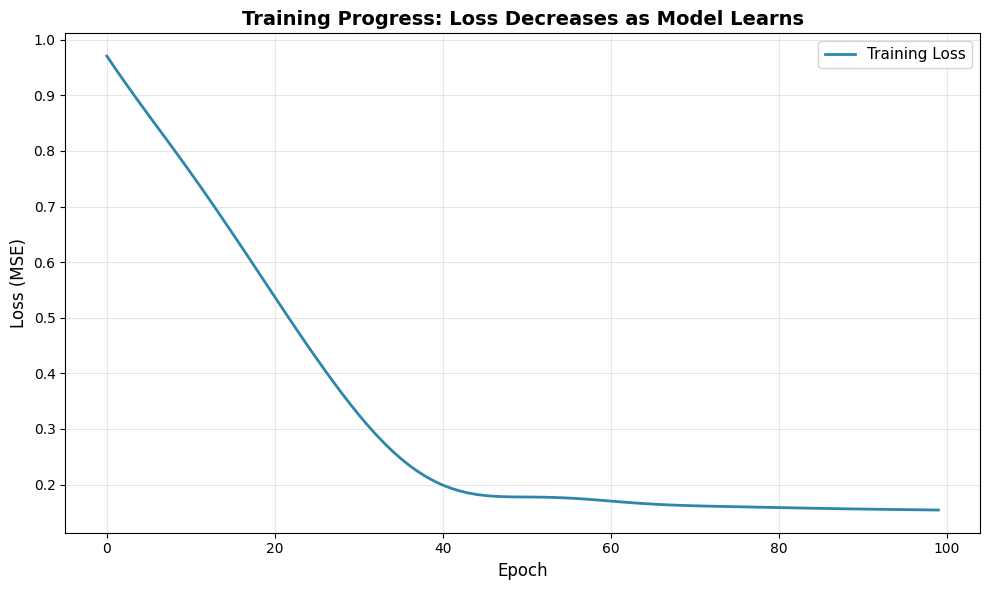


Initial loss: 0.9706
Final loss: 0.1543
Loss reduction: 84.1%


In [11]:
# Plot training loss curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2, color='#2E86AB')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Progress: Loss Decreases as Model Learns', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_progress.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nInitial loss: {train_losses[0]:.4f}")
print(f"Final loss: {train_losses[-1]:.4f}")
print(f"Loss reduction: {(train_losses[0] - train_losses[-1]) / train_losses[0] * 100:.1f}%")

> **Reading the curve**: The steep drop in the first epochs shows rapid initial learning: the model quickly picks up obvious patterns ("newer cars cost more", "higher mileage means lower price"). By epoch 40, the curve flattens dramatically, indicating the model has mostly converged. 
> 
> Training beyond 100 epochs would provide minimal additional benefit -> This could be a good stopping point to save computation time and resources.

## Step 7: Compare predictions before and after training

Let's see how much the model improved by comparing its initial random predictions to its trained predictions.

> **A note on evaluation**: We're using Mean Absolute Error (MAE) to measure accuracy in intuitive dollar terms. This differs from our training loss (MSE), but both measure prediction error: MAE just tells us "on average, how many dollars off are our predictions?"

In [12]:
# Get trained model predictions (on same 200 samples we evaluated initially)
with torch.no_grad():
    trained_predictions = model(X_tensor[:200]).numpy()

# Convert back to original price scale
trained_predictions_orig = scaler_y.inverse_transform(trained_predictions)

print("Before vs. After Training (first 10 examples):")
print("=" * 70)
print(f"{'Actual Price':>15} | {'Initial Pred':>15} | {'Trained Pred':>15}")
print("-" * 70)

for i in range(10):
    actual = y_orig[i, 0]
    initial_pred = initial_predictions_orig[i, 0]
    trained_pred = trained_predictions_orig[i, 0]
    
    print(f"${actual:>13,.2f} | ${initial_pred:>13,.2f} | ${trained_pred:>13,.2f}")

# Calculate overall improvement
initial_mae = np.mean(np.abs(y_orig - initial_predictions_orig))
trained_mae = np.mean(np.abs(y_orig - trained_predictions_orig))
improvement_pct = (initial_mae - trained_mae) / initial_mae * 100

print("\n" + "=" * 70)
print(f"Average absolute error (before): ${initial_mae:>10,.2f}")
print(f"Average absolute error (after):  ${trained_mae:>10,.2f}")
print(f"Error reduction:                  {improvement_pct:>9.1f}%")
print("=" * 70)

Before vs. After Training (first 10 examples):
   Actual Price |    Initial Pred |    Trained Pred
----------------------------------------------------------------------
$    30,246.21 | $    24,767.50 | $    30,734.20
$    22,785.75 | $    25,218.78 | $    24,905.78
$    25,760.29 | $    25,037.17 | $    24,710.98
$    25,638.00 | $    25,181.63 | $    27,328.71
$    21,021.39 | $    25,182.86 | $    21,029.49
$    25,509.93 | $    24,741.07 | $    28,131.22
$    12,268.21 | $    25,530.54 | $    12,745.12
$    27,783.74 | $    25,412.02 | $    24,728.74
$    27,392.18 | $    25,188.25 | $    27,324.82
$    28,434.53 | $    25,387.19 | $    28,184.18

Average absolute error (before): $  4,053.68
Average absolute error (after):  $  1,596.40
Error reduction:                       60.6%


> **The power of training**: The model went from an average error of ~$4,050 to ~$1,600, which is a 60% improvement! Notice that some individual predictions got worse while others got much better. This is expected: the model learns patterns that minimize *average* error across all 1,000 cars, not memorize individual examples. 
> 
> It's the overall performance that matters, and that improved dramatically-all learned automatically through gradient descent and backpropagation, without any hand-coded rules.


## Conclusion

Congratulations! You've just witnessed the complete neural network training process from scratch.

**What you've learned:**

- [x] **The 5-step training loop** - Forward → Loss → Zero grads → Backward → Update
- [x] **PyTorch automates the hard parts** - `loss.backward()` handles all backpropagation math
- [x] **Training is iterative** - Many small weight adjustments accumulate into learned patterns
- [x] **Loss curves tell the story** - Decreasing loss means the model is learning
- [x] **Gradient descent works** - Random weights become predictive through systematic optimization

> **Key insight**: Deep learning models\*—whether predicting car prices, recognizing images, or generating text—train using these same five steps. The model architecture, loss function, and optimizer may differ, but this core loop remains the same. Master this, and you understand the foundation of neural network training.

_\* Except for some specialized approaches like reinforcement learning or self-supervised learning._

##### Next steps to explore:

- [ ] **Can you print gradient values?** Add `print(model.fc1.weight.grad[0, 0])` after `loss.backward()` to see individual gradients. Watch how they change as loss decreases—large gradients early (steep slope), small gradients later (near minimum).

- [ ] **What happens with different learning rates?** Try `lr=0.0001` (very slow) and `lr=0.01` (might be unstable). See how learning rate affects convergence speed and stability.